# GMM ensemble

Using an ensemble of Gaussian Mixture Models (GMMs) to find the regions of similar sea level variability. In voting the posteriori probability given by each GMM is taken into account as weights for voting. There is a limitation to the size of the classes, to avoid having classes with only a few grid points. Results are saved into NetCDF files, and class means from individual models are saved into a .npy file.
- **Input:**
    - output from s02_PCA; EOF maps (spatial component), longitude, and latitude, saved as separate .npy files
- **Output:**
    - **Data:** NetCDF4 and .mat files
        - [expname]_t[n].nc - contains gridded classification, likelihood and training/test set mask (where test set is 0 and training set is 1)
        - [expname]_t[n]_individual.nc - contains the results from all individual models; gridded classification, probability and training/test set mask
        - [expname]_t[n]_class_means.npy - contains class means from individual GMMs (K x D x N)
    - **Figures:** classification and likelihood, classification and probability for the first 10 models (no projection, longitude is treated as x and latitude as y)
- **Steps:**
    - create model name
    - load the data, reshape it and remove the empty (land) grid points
    - splitting the data into training and test set
    - ensemble:
        - fit a GMM with the training set
        - evaluate on both the training and the test set
        - combine the training and test set again
    - match the classes from individual models based on class means
    - soft voting (voting based on the probability for each class) for each grid point; dropping the small classes and reassigning the grid points to the class with the next highest vote
    - dropping the empty classes
    - reshaping the results back to grids
    - saving the results
    - plotting the ensemble classification
    - plotting the individual models (first 10 only)
- name of the experiment is determined from the region, time span and the hyperparameters of the ensemble:
- the parameter overwrite = True allows to overwrite the last model output instead of creating a new folder for it (in case the script previously failed)

Author: Lea Poropat <br>
Last edited: 2023-12-11

### <font color = "red">Parameters</font>

In [1]:
# region
reg = 'NWeuropeSeas'

# time span
y1 = 1995
y2 = 2021

# number of PCs used
nPC = 3

# number of classes in the GMM
K = 4

# file names
pth = r'../Data/s02_PCA/' + reg + '_' + str(y1) + '-' + str(y2) + '_'
fleof = pth + 'eof_maps.npy'
fllon = pth + 'Lon.npy'
fllat = pth + 'Lat.npy'
flev = pth + 'exp_var.npy'

# percent of training set
train_size = 0.9

# correlation cutoff
corrlim = 0.98

# minimal allowed class size (number of gridpoints in combined train and test set)
minsize = 100

# number of ensemble members (needs to be 200!)
N = 200

# overwrite the last model run?
overwrite = False

# model name (experiment number will be appended later)
modelname = reg + '_' + str(y1) + '-' + str(y2) + '_PCs' + str(nPC) + \
    '_K' + str(K) + \
    '_tr' + str(int(train_size*100)) + \
    '_r' + str(int(corrlim*100)).zfill(2) + \
    '_gp' + str(minsize) + \
    '_N' + str(N) + \
    '_t'

# results
res = r'../Data/s04_ClassificationResults/'

# figures
figens = r'../Figures/s04_ClassificationResults/'
figind = r'../Figures/s04_GMMindividualModels/'

### Loading the libraries

In [2]:
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import matplotlib as mpl
from scipy.stats import pearsonr
import scipy.io
import time

In [3]:
# timing starts here
starttime = time.time()

### Model name
Model name is based on the parameters of the ensemble. It also includes a version number, in case of multiple ensemble runs. Version number is detected automatically from the existence of the figure with the results. If overwrite is set to True it will overwrite the last results.

In [4]:
t = 1
while True:
    if (os.path.exists(figens + modelname + str(t) + '.png') == False):
        # looping until a try that doesn't exist is found (can be try 1 as well)
        
        if (overwrite == True and t > 1):
            # if the experiment replaces the last previous one, then the experiment number is one less than current t
            modelname = modelname + str(t-1)
            print('Model: %s' % modelname)
            t = t-1
        else:
            # if the experiment has a new number (either because overwrite = False or because there are no previous
            # experiments at all) the model number is the current t
            modelname = modelname + str(t)
            print('Model: %s' % modelname)
        # exiting the loop
        break
        
    # updating t
    t = t + 1

Model: NWeuropeSeas_1995-2021_PCs3_K4_tr90_r98_gp100_N200_t2


### Loading and reshaping data + removing empty grid points

In [5]:
# loading the data
X0 = np.load(fleof)
Lon0 = np.load(fllon)
Lat0 = np.load(fllat)
expvar = np.load(flev)
nlat, nlon = np.shape(Lon0)

# 1D longitude and latitude
lon = Lon0[0, :]
lat = Lat0[:, 0]

# reshape to 2D
X1 = np.reshape(X0,(len(X0),-1),'C').transpose()
Lon1 = np.reshape(Lon0, -1, 'C').transpose()
Lat1 = np.reshape(Lat0, -1, 'C').transpose()

# remove land and empty grid points
ind_ocean = np.squeeze(np.nonzero(np.squeeze(~np.all(np.isnan(X1), axis = 1))))
X2 = X1[ind_ocean, :]
Lon2 = Lon1[ind_ocean]
Lat2 = Lat1[ind_ocean]

# check if there are any gaps in the dataset
gaps = np.argwhere(np.any(np.isnan(X2), axis = 1))
gaps = np.squeeze(gaps)

# printing the summary
if len(gaps)==0:
    print('Land grid points and grid points with missing data removed!')
else:
    print('There are still gaps in the data!')
print('Shape of the dataset after removing empty points: %s' % str(np.shape(X2)))

Land grid points and grid points with missing data removed!
Shape of the dataset after removing empty points: (10354, 324)


### Selecting the principal components that will be used

In [6]:
X = X2[:, :nPC]

### Train-test set split

In [7]:
# all ensemble members will use the same training set
ind = np.array(range(0, len(X)))

Xtr, Xte, Lontr, Lonte, Lattr, Latte, indtr, indte = train_test_split(X, Lon2, Lat2, ind, train_size = train_size)
ntr = np.shape(Xtr)[0]
nte = np.shape(Xte)[0]

# training vs test set mask (training = 1, test = 0)
training_mask = np.zeros(np.shape(ind))
training_mask[indtr] = 1

### GMM

In [8]:
# timing of GMMs only starts here
starttime2 = time.time()

# creating the results matrices
y = np.empty((ntr+nte, N), dtype = np.int16)
proba = np.empty((ntr+nte, N))
class_means = np.empty((K, nPC, N))

for i in range(N):
    # creating the model
    gmm = GaussianMixture(n_components = K, covariance_type = 'full', tol = 1e-3, \
                          max_iter = 200, n_init = 3, init_params = 'kmeans', verbose = 0)
    
    # fitting the model
    gmm.fit(Xtr)
    
    # predicting the class for each grid point
    ytr = gmm.predict(Xtr)
    yte = gmm.predict(Xte)
    
    # predicting the probability for each point
    temp = gmm.predict_proba(Xtr)
    probatr = np.amax(temp, axis = 1)
    temp = gmm.predict_proba(Xte)
    probate = np.amax(temp, axis = 1)
    
    # saving the class means
    class_means[:, :, i] = gmm.means_
    
    # combining the train and test set again
    y[indtr, i] = ytr
    y[indte, i] = yte
    proba[indtr, i] = probatr
    proba[indte, i] = probate
    
    # printing the ensemble number
    if ((N-i-1) % 25 == 0):
        print('%4i' % (N-i))
    else:
        print('%4i' % (N-i), end = ' ')
        
# timing of GMMs only ends here (does not account for longer ensemble class matching)
print('Execution time: %s seconds' % (time.time() - starttime2))

 200  199  198  197  196  195  194  193  192  191  190  189  188  187  186  185  184  183  182  181  180  179  178  177  176
 175  174  173  172  171  170  169  168  167  166  165  164  163  162  161  160  159  158  157  156  155  154  153  152  151
 150  149  148  147  146  145  144  143  142  141  140  139  138  137  136  135  134  133  132  131  130  129  128  127  126
 125  124  123  122  121  120  119  118  117  116  115  114  113  112  111  110  109  108  107  106  105  104  103  102  101
 100   99   98   97   96   95   94   93   92   91   90   89   88   87   86   85   84   83   82   81   80   79   78   77   76
  75   74   73   72   71   70   69   68   67   66   65   64   63   62   61   60   59   58   57   56   55   54   53   52   51
  50   49   48   47   46   45   44   43   42   41   40   39   38   37   36   35   34   33   32   31   30   29   28   27   26
  25   24   23   22   21   20   19   18   17   16   15   14   13   12   11   10    9    8    7    6    5    4    3    2    1


### Combining the results from the ensemble

In [9]:
def getSizeOfNestedList(listOfElem):
    ''' Get number of elements in a nested list'''
    count = 0
    # Iterate over the list
    for elem in listOfElem:
        # Check if type of element is list
        if type(elem) == list:  
            # Again call this function to get the size of this element
            count += getSizeOfNestedList(elem)
        else:
            count += 1    
    return count

In [10]:
# finding the list of all classes that appear in any of the models (classes with corr >= corrlim are considered same)
# the first N classes are from the 1st ensemble member
classes_all = np.expand_dims(class_means[0, :, 0], 0)
classes_matching = np.empty((K, N), dtype = np.int64)
classes_matching[0, 0] = 0
class_means_new = np.expand_dims(class_means[0, :, 0], (0, 1)).tolist()

num = getSizeOfNestedList(class_means_new)

# comparing the class means from the other ensemble members with the growing list of separate classes
for i in range(0, N):
    for j in range(K):
        
        if ((i == 0) and (j == 0)):
            continue
        
        r = np.empty((np.shape(classes_all)[0]))
        
        for k in range(len(r)):
            r[k] = pearsonr(class_means[j, :, i], classes_all[k, :])[0]
            
            
        if (np.amax(r) >= corrlim):
            temp = np.argmax(r)
            classes_matching[j, i] = temp
            class_means_new[temp].append(class_means[j, :, i].tolist())
        else:
            classes_all = np.concatenate((classes_all, np.reshape(class_means[j, :, i], (1, nPC))))
            classes_matching[j, i] = np.shape(classes_all)[0]-1
            class_means_new.append(np.expand_dims(class_means[j, :, i], 0).tolist())
    
    # finding and printing the number of class means after each ensemble member is sorted
    temp = num
    num = getSizeOfNestedList(class_means_new)
            
tot_class_num = np.shape(classes_all)[0]

In [11]:
pd.DataFrame(classes_matching)

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0,3,3,1,1,0,0,1,1,0,...,2,1,1,1,0,1,2,0,2,1
1,1,1,2,0,2,3,3,3,3,2,...,1,3,2,2,3,2,1,3,1,2
2,2,2,1,2,0,1,1,0,2,1,...,3,0,0,0,1,0,0,1,0,0
3,3,0,0,3,3,2,2,2,0,3,...,0,2,3,3,2,3,3,2,3,3


In [12]:
# assigning new class numbers to the results
yNew = np.empty((ntr+nte, N), dtype = np.int64)

for i in range(N):    
    for j in range(K):
        ind = np.squeeze(np.nonzero(y[:, i] == j))
        yNew[ind, i] = classes_matching[j, i]

In [13]:
# soft voting + likelihood (probability cutoff + weighted votes + removing small classes)
def soft_vote(x, proba, nan = -99, minclass = 100):
    # array with samples as rows and ensemble models as columns
    
    # maority voting for the whole array
    x2 = np.empty((np.shape(x)[0]), dtype = np.int16)
    like = np.empty((np.shape(x)[0]))
    votes = []
    
    for i in range(np.shape(x)[0]):
        mask = np.nonzero(x[i, :] == nan)        
        classes = np.delete(x[i, :], mask) # removing empty and too weak votes
        weights = np.delete(proba[i, :], mask)
        votes.append(np.bincount(classes, weights = weights)) # number of votes for each class
        
        if len(votes[i]) == 0:
            x2[i] = -1
            like[i] = 0
        else:
            x2[i] = votes[i].argmax()       # class with the highest vote
            like[i] = votes[i].max()/np.shape(x)[1] # how many voted for this class
            
    # check if some of the classes are too small - if yes, use the next best not-too-small class for the grid points
    # that belong to the small classes
    
    # finding small classes
    maxclass = np.max(x)
    class_size = np.empty((maxclass+1), dtype = np.int32)
    for i in range(maxclass + 1):
        class_size[i] = len(np.nonzero(x2 == i)[0])
        
    # small classes
    small_classes = np.nonzero(class_size <= minclass)[0]
    
    # finding a new class for each of the grid points belonging to a small class
    for i in range(np.shape(x2)[0]):
        if np.isin(x2[i], small_classes, assume_unique = True):     #x2[i] in small_classes:
            # deleting the votes that blong to the small classes (temp = votes from only large enough classes)
            temp = np.zeros((len(votes[i])), dtype = np.int16)
            for k in range(len(temp)):
                if not np.isin(k, small_classes, assume_unique = True):  # k not in small_classes:
                    temp[k] = votes[i][k]
            
            # choosing the second best vote (or -1 if there are no other votes)
            #print((i, x2[i]), end = ' -> ')
            if np.any(temp):  # if any elements is not zero
                x2[i] = temp.argmax()
            else:
                x2[i] = -1

            like[i] = temp.max()/np.shape(x)[1]
            
    return [x2, like]

In [14]:
# soft voting
ySV, like = soft_vote(yNew, proba, nan = -99, minclass = minsize)

In [15]:
# how many grid points exist in each class
points_per_class = np.empty((tot_class_num))
for i in range(tot_class_num):
    points_per_class[i] = len(np.squeeze(np.nonzero(ySV == i)))
    print('class %2i: %8i' % (i, points_per_class[i]))

class  0:     1190
class  1:     4317
class  2:     3651
class  3:     1196


In [16]:
# dropping the empty classes
classes = np.arange(tot_class_num)
ind = np.squeeze(points_per_class > 0)
classes = classes[ind]
new_class_num = len(classes)
classes_new = np.squeeze(classes_all[ind, :])
class_means_new = [a for (a, m) in zip(class_means_new, ind) if m]
print('Total number of classes: %2i' % tot_class_num)
print('Final number of classes: %2i' % new_class_num)

Total number of classes:  4
Final number of classes:  4


In [17]:
# changing the class numbers to be from 1 to new_class_num (before the classes started at 0!)
for i in range(new_class_num):
    ySV[ySV == classes[i]] = i + 1001
ySV = ySV - 1000

In [18]:
# how many grid points exist in each class
points_per_class = np.empty((new_class_num))
for i in range(new_class_num):
    points_per_class[i] = len(np.squeeze(np.nonzero(ySV == i+1)))
    print('class %2i: %8i' % (i+1, points_per_class[i]))

class  1:     1190
class  2:     4317
class  3:     3651
class  4:     1196


In [19]:
# timing ends here
print('Execution time: %s seconds' % (time.time() - starttime))

Execution time: 47.72014880180359 seconds


### Reshaping the results back to grid

In [20]:
# training vs test set mask
mask_grid = np.nan * np.ones((nlat*nlon), dtype = np.int16)
mask_grid[ind_ocean] = np.squeeze(training_mask)
mask_grid = np.reshape(mask_grid, (nlat, nlon), 'C')

In [21]:
# ensemble results
res_grid = np.nan * np.ones((nlat*nlon), dtype = np.int16)
res_grid[ind_ocean] = np.squeeze(ySV)
res_grid = np.reshape(res_grid, (nlat, nlon),'C')

like_grid = np.nan * np.ones((nlat*nlon))
like_grid[ind_ocean] = np.squeeze(like)
like_grid = np.reshape(like_grid, (nlat, nlon), 'C')

In [22]:
# individual model results
# also adding 1 to the classification to change class numbers from 0 to K-1 to 1 to K
mod_grid = np.nan * np.ones((nlat*nlon, N), dtype = np.int16)
mod_grid[ind_ocean] = y
mod_grid = np.reshape(mod_grid, (nlat, nlon, N), 'C')
mod_grid = mod_grid + 1

proba_grid = np.nan * np.ones((nlat*nlon, N))
proba_grid[ind_ocean] = proba
proba_grid = np.reshape(proba_grid, (nlat, nlon, N), 'C')

### Save the results

In [23]:
# ensemble results
results = xr.Dataset(data_vars = {"classification" : (("longitude", "latitude"), np.swapaxes(res_grid, 0, 1)), \
                                 "likelihood" : (("longitude", "latitude"), np.swapaxes(like_grid, 0, 1)), \
                                 "training_set" : (("longitude", "latitude"), np.swapaxes(mask_grid, 0, 1))}, \
                    coords = {"longitude" : lon, "latitude" : lat})
results.to_netcdf(res + modelname + '.nc')


# results for the individual models (model number is the 3rd dimension)
results = xr.Dataset(data_vars = {"classification" : (("longitude", "latitude", "model"), np.swapaxes(mod_grid, 0, 1)), \
                                 "likelihood" : (("longitude", "latitude", "model"), np.swapaxes(proba_grid, 0, 1)), \
                                 "training_set" : (("longitude", "latitude"), np.swapaxes(mask_grid, 0, 1))}, \
                    coords = {"longitude" : lon, "latitude": lat, "model" : range(1, N+1)})
results.to_netcdf(res + modelname + '_individual.nc')

# individual models class means
np.save(res + modelname + '_class_means.npy', class_means, allow_pickle = False)

### Plotting the classification results

In [24]:
def plot_classification_results(x, y, c, p, filename, title = '', showfig = False):
    # function plots classification on the left and probability/likelihood on the right
    # it adds the figure title and saves the figure
    # it works for up to 20 classes because of the colormap it uses
    
    # --- Number of classes ---
    class_num = int(np.nanmax(c) - np.nanmin(c) + 1)
    if (class_num > 20):
        print("There are too many classes to plot with this function!")
        exit()
    
    # --- Colormaps ---
    # creating a new colormap with class_num colors (2 colormaps are concatenated )
    cmapc = cm.tab20b
    cind = [x/20 for x in range(20)]
    cmapn = []
    for i in range(20):
        cmapn.append(cmapc(cind[i]))
    cmapn = cmapn[:class_num]
    my_cmapc = ListedColormap(cmapn, name='cmapc')

    # gradient colormap for the likelihood/probability
    cmapg = cm.summer(np.linspace(0, 1, 10))
    my_cmapg = ListedColormap(cmapg, name = 'cmapg')

    
    # --- Plotting ---
    fig, ax = plt.subplots(1, 2, sharex = 'none')
    fig.set_figwidth(11)
    fig.set_figheight(5)
    
    # left plot: classification
    fl = ax[0].pcolormesh(x, y, c, shading = 'nearest', cmap = my_cmapc, vmin = 1, vmax = class_num+1)

    labels = list(range(1, class_num+1))
    ticks = [a + 0.5 for a in labels]
    cbl = plt.colorbar(fl, ax = ax[0], location = 'bottom', pad = 0.1, ticks = ticks)
    cbl.ax.set_xticklabels(labels)
    cbl.ax.tick_params(labelsize = 16)

    # right plot: likelihood/probability
    fr = ax[1].pcolormesh(x, y, p, shading = 'nearest', cmap = my_cmapg, vmin = 0, vmax = 1)

    cbr = plt.colorbar(fr, ax = ax[1], location = 'bottom', pad = 0.1)
    cbr.ax.tick_params(labelsize = 16)
    
    # --- Adding the title ---
    fig.suptitle(title, fontsize = 16)

    # --- Saving the figure ---
    fig.savefig(filename)
    if showfig == False:
        plt.close()

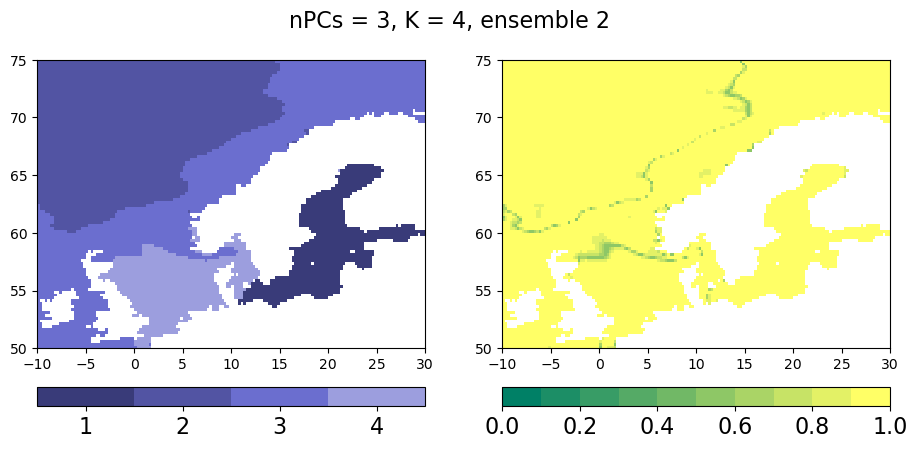

In [25]:
# plotting the ensemble results
figname = figens + modelname + '.png'
figtitle = 'nPCs = ' + str(nPC) + ', K = ' + str(K) + ', ensemble ' + str(t)
plot_classification_results(lon, lat, res_grid, like_grid, figname, figtitle, True)

In [26]:
# plotting the results of the individual models (10 only)
for i in range(10):
    figname = figind + modelname + '_' +str(i+1).zfill(2)
    figtitle = 'nPCs = ' + str(nPC) + ', K = ' + str(K) + ', ensemble ' + str(t) + ', model ' + str(i+1)
    plot_classification_results(lon, lat, mod_grid[:, :, i], proba_grid[:, :, i], figname, figtitle, False)